In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost.sklearn import XGBClassifier


In [4]:
base_path = "data/ROSMAP"
methy_path = os.path.join(base_path, "methy.csv")
mirna_path = os.path.join(base_path, "mirna.csv")
mrna_path = os.path.join(base_path, "mrna.csv")
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise ValueError("Data Not found")

In [5]:
methy_df = pd.read_csv(methy_path, index_col=0)
mirna_df = pd.read_csv(mirna_path, index_col=0)
mrna_df = pd.read_csv(mrna_path, index_col=0)
print(methy_df.shape, mirna_df.shape, mrna_df.shape)


(351, 202) (351, 202) (351, 202)


In [6]:
methy_df_wol = methy_df.drop('Label', axis=1)
mirna_df_wol = mirna_df.drop('Label', axis=1)
mrna_df_wol = mrna_df.drop('Label', axis=1)
methy_df_wos = methy_df_wol.drop('Split', axis=1)
mirna_df_wos = mirna_df_wol.drop('Split', axis=1)
mrna_df_wos = mrna_df_wol.drop('Split', axis=1)

combined_df = pd.concat([methy_df_wos, mirna_df_wos, mrna_df_wos], axis=1)
combined_df['Label'] = methy_df['Label']

In [76]:
combined_df.shape

(351, 602)

In [77]:
combined_df.describe()

,ENSG00000161896.6,ENSG00000248714.2,ENSG00000242349.1,ENSG00000006831.9,ENSG00000261195.1,ENSG00000143409.11,ENSG00000140931.15,ENSG00000185499.11,ENSG00000101265.10,ENSG00000153048.6,ENSG00000037897.12,ENSG00000155980.6,ENSG00000111181.8,ENSG00000146966.8,ENSG00000164050.8,ENSG00000244239.1,ENSG00000227392.1,ENSG00000151552.7,ENSG00000051128.13,ENSG00000172935.8,ENSG00000233487.6,ENSG00000140682.14,ENSG00000072864.8,ENSG00000016602.8,ENSG00000178796.8,ENSG00000150760.8,ENSG00000042062.7,ENSG00000204219.5,ENSG00000105419.11,ENSG00000166535.15,ENSG00000119403.9,ENSG00000142173.10,ENSG00000249436.1,ENSG00000065361.8,ENSG00000165406.9,ENSG00000105655.11,ENSG00000183773.10,ENSG00000086159.8,ENSG00000159176.9,ENSG00000165912.11,...,hsa-miR-651,hsa-miR-656,hsa-miR-660,hsa-miR-664,hsa-miR-744,hsa-miR-767-5p,hsa-miR-769-3p,hsa-miR-769-5p,hsa-miR-770-5p,hsa-miR-873,hsa-miR-885-5p,hsa-miR-891b,hsa-miR-934,hsa-miR-1180,hsa-miR-1206,hsa-miR-1246,hsa-miR-1248,hsa-miR-1260,hsa-miR-1266,hsa-miR-1275,hsa-miR-1283,hsa-miR-1297,hsa-miR-1299,hsa-miR-1308,hsa-miR-1912,hsa-miR-2114,hsa-miR-2117,ebv-miR-BART6-5p,ebv-miR-BART8,ebv-miR-BART9,hcmv-miR-UL70-3p,hsv1-miR-H1,hsv1-miR-H3,hsv1-miR-H8,kshv-miR-K12-2,kshv-miR-K12-4-5p,kshv-miR-K12-9,mcv-miR-M1-5p,Label,Split
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.102791,0.098358,0.105450,0.443426,0.226527,0.328801,0.218956,0.218900,0.398180,0.489418,0.211936,0.848631,0.396071,0.340209,0.581023,0.261172,0.073107,0.778765,0.447239,0.119557,0.193342,0.180332,0.253901,0.100948,0.226838,0.335044,0.181234,0.235628,0.606134,0.138007,0.354841,0.289061,0.264270,0.373756,0.269331,0.480815,0.630695,0.080258,0.832048,0.369217,...,0.393353,0.489737,0.355737,0.572225,0.324142,0.307614,0.319157,0.305904,0.260372,0.421472,0.597248,0.240363,0.286717,0.495936,0.339866,0.249694,0.261696,0.680970,0.250429,0.267667,0.475930,0.367604,0.248673,0.295183,0.277925,0.260742,0.257472,0.346989,0.345206,0.265165,0.272610,0.246994,0.245754,0.257303,0.246567,0.330728,0.362321,0.299876,0.518519,0.698006
std,0.041801,0.041315,0.040412,0.041696,0.066241,0.048708,0.043396,0.059123,0.042692,0.045812,0.038569,0.055103,0.060662,0.034899,0.050316,0.049843,0.033405,0.052895,0.050606,0.040835,0.051940,0.040111,0.042510,0.039978,0.065740,0.044714,0.062901,0.040919,0.058230,0.054995,0.035776,0.053523,0.070913,0.053650,0.034968,0.055986,0.041775,0.034635,0.053310,0.041983,...,0.034697,0.022210,0.029022,0.014142,0.052033,0.037719,0.039992,0.039407,0.043950,0.028965,0.025693,0.050153,0.041173,0.022572,0.040300,0.085623,0.045491,0.054583,0.047554,0.060042,0.022446,0.037570,0.061757,0.052442,0.041134,0.049373,0.060261,0.036573,0.057965,0.042473,0.042883,0.049000,0.048568,0.053267,0.048427,0.042657,0.038231,0.048841,0.500370,0.459778
min,0.010077,0.000000,0.008678,0.211588,0.000000,0.184434,0.088366,0.074582,0.296670,0.375087,0.100223,0.615240,0.234546,0.272931,0.419217,0.102486,0.000000,0.628005,0.336228,0.033233,0.024650,0.056361,0.135869,0.007266,0.027154,0.137652,0.052224,0.110499,0.435834,0.022105,0.241474,0.171358,0.051172,0.186151,0.125337,0.360604,0.425079,0.010077,0.655174,0.236689,...,0.308165,0.407456,0.2

In [78]:
def get_train_test(df):
    train_df = df[df['Split'] == 1].drop('Split', axis=1)
    test_df = df[df['Split'] == 0].drop('Split', axis=1)
    y_train = train_df.pop('Label')
    y_test = test_df.pop('Label')
    return train_df, test_df, y_train, y_test

In [79]:
X_train_df, X_test_df, y_train, y_test = get_train_test(combined_df)

In [80]:
X_train_df.shape, X_test_df.shape, y_train.shape, y_test.shape

((245, 600), (106, 600), (245,), (106,))

In [81]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train_df, 0.80)
print('correlated features: ', len(set(corr_features)) )

correlated features:  73


In [82]:
X_train_df.drop(labels=corr_features, axis=1, inplace=True)
X_test_df.drop(labels=corr_features, axis=1, inplace=True)

In [83]:
X_train_df.shape

(245, 527)

In [84]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(X_train_df, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [85]:
y_pred = clf.predict(X_test_df)

In [86]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy: ", accuracy)
precision = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1)
print("Precision: ", precision)
recall = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)
print("Recall: ", recall)

Accuracy:  0.8301886792452831
Precision:  0.8245614035087719
Recall:  0.8545454545454545


In [87]:
sfm = SelectFromModel(clf, threshold=1e-5)
sfm.fit(X_train_df, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                threshold=1e-05)

In [88]:
selected_features = X_train_df.columns[sfm.get_support()]

In [89]:
print("Selected Features: ", selected_features)

Selected Features:  Index(['ENSG00000161896.6', 'ENSG00000248714.2', 'ENSG00000242349.1',
       'ENSG00000006831.9', 'ENSG00000261195.1', 'ENSG00000143409.11',
       'ENSG00000140931.15', 'ENSG00000185499.11', 'ENSG00000101265.10',
       'ENSG00000153048.6',
       ...
       'ebv-miR-BART8', 'ebv-miR-BART9', 'hcmv-miR-UL70-3p', 'hsv1-miR-H1',
       'hsv1-miR-H3', 'hsv1-miR-H8', 'kshv-miR-K12-2', 'kshv-miR-K12-4-5p',
       'kshv-miR-K12-9', 'mcv-miR-M1-5p'],
      dtype='object', length=520)


In [90]:
selected_features.shape

(520,)

In [91]:
feature_imp = pd.Series(clf.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)

In [92]:
feature_imp

hsa-miR-132          0.015108
hsa-miR-129-5p       0.012746
ENSG00000227544.2    0.010539
ENSG00000105643.3    0.008223
hsa-miR-146b-5p      0.007877
                       ...   
hsa-miR-106b         0.000000
cg03870261           0.000000
hsa-miR-590-5p       0.000000
hsa-miR-448          0.000000
cg07654934           0.000000
Length: 527, dtype: float64

In [93]:
top_n_features = feature_imp.index[:50]

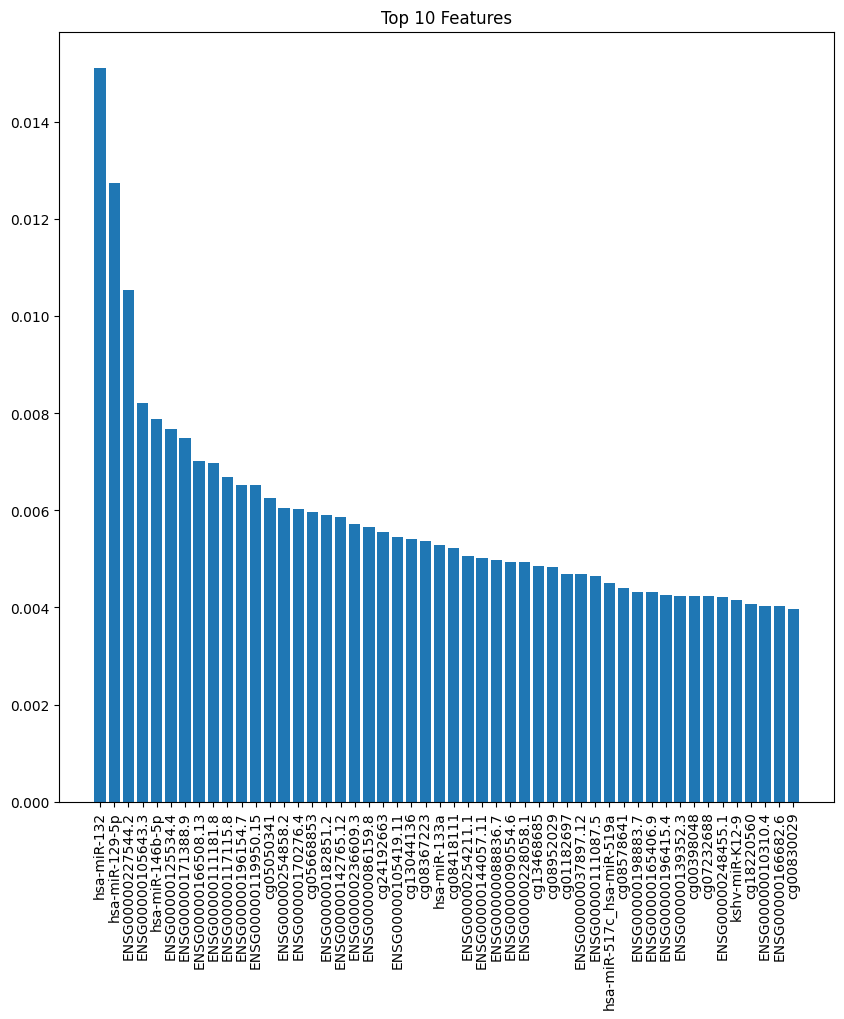

In [94]:
#plot top n features
plt.figure(figsize=(10,10))
plt.title("Top 10 Features")
plt.bar(range(len(top_n_features)), feature_imp[top_n_features], align='center')
plt.xticks(range(len(top_n_features)), top_n_features, rotation='vertical')
plt.show()


In [95]:
clf1 = XGBClassifier()  #learning_rate=0.1, max_depth=3, min_child_weight=9, n_estimators=100, nthread=1, subsample=0.8,
                    # gamma =0.01, seed=1234)

In [96]:
clf1.fit(X_train_df, y_train)
y_predxgb = clf1.predict(X_test_df)

In [97]:
accuracy_xgb = np.sum(y_predxgb == y_test) / len(y_test)
print("Accuracy: ", accuracy_xgb)
precision_xgb = np.sum((y_predxgb == 1) & (y_test == 1)) / np.sum(y_predxgb == 1)
print("Precision: ", precision_xgb)
recall_xgb = np.sum((y_predxgb == 1) & (y_test == 1)) / np.sum(y_test == 1)
print("Recall: ", recall_xgb)


Accuracy:  0.8207547169811321
Precision:  0.8103448275862069
Recall:  0.8545454545454545
